# Colab or Kaggle

In [ ]:
#ColaboratoryかKaggleNotebookか判別
import sys
import os
from pathlib import Path

MAIN_INPUT_NAME = "vinbigdata-512-image-dataset"
MAIN_INPUT_ZIP = f'../input/{MAIN_INPUT_NAME}.zip'


if 'google.colab' in sys.modules:  # colab環境
    INPUT = Path('/content/input/')

    # drive mount
    from google.colab import drive
    drive.mount('/content/drive/')

    # working dir に移動
    os.chdir('drive/MyDrive/git/kaggle-vinbigdata-xray/working')
    print("cwd:", os.getcwd())

    # 必要な input を指定先へ unzip
    !unzip -q {MAIN_INPUT_ZIP} -d {INPUT}
    print("unzip INPUT")
    
elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    INPUT = Path('../input/')


Mounted at /content/drive/
cwd: /content/drive/MyDrive/git/kaggle-vinbigdata-xray/working
unzip INPUT


# W&BとCFG

In [ ]:
#W&B
!pip install wandb -qqq
import wandb
!wandb login

wandb.init(
    project="vinbigdata-class-filter", 
)

wandb: Currently logged in as: kami (use `wandb login --relogin` to force relogin)


In [ ]:
# configの設定
CFG={
    "learning_rate": 0.02,
    # "dropout": 0.2,
    "debug": False, 
    "apex":False,
    "print_freq":100,
    "num_workers": 2,
    "architecture": "resnet", # ["efficientnet", "vit", "resnet"]
    "model_name": 'resnext101_32x8d',
    "size": 512,
    "scheduler": 'CosineAnnealingWarmRestarts', # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    "epochs": 15,
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    "T_0": 10, # CosineAnnealingWarmRestarts
    "lr":1e-4,
    "min_lr":1e-6,
    "batch_size":8,
    "weight_decay":1e-6,
    "gradient_accumulation_steps":1,
    "max_grad_norm":1000,
    "seed":42,

    "target_size":2,
    "target_col":'label',
    "n_fold":5,
    "trn_fold":[0], # [0, 1, 2, 3, 4], (n_fold:5) 実験では fold 0 のみで十分
    "train":True,
    "inference":False,
  }

#-----------------------------------
# for wandb
#-----------------------------------
# config
wandb.config.update(CFG)
# run name
import datetime
now = datetime.datetime.now()
wandb.run.name = CFG["model_name"] +"_" + now.strftime('%Y.%m.%d.%H.%M') 
# tag
wandb.run.tags = [CFG["architecture"]]

# Data Loading

In [ ]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
os.listdir(os.path.join(INPUT, MAIN_INPUT_NAME, "vinbigdata"))

['test', 'train.csv', 'test.csv', 'sample_submission.csv', 'train']

In [ ]:
train = pd.read_csv(os.path.join(INPUT, MAIN_INPUT_NAME, "vinbigdata","train.csv"))
train = train.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
train["label"] = (train["num_normal_annotations"] == 3).astype(int)  # 3人とも異常なしを1とする

test = pd.read_csv(os.path.join(INPUT, MAIN_INPUT_NAME, "vinbigdata","sample_submission.csv"))

display(train.head())
display(test.head())

,image_id,num_normal_annotations,label
0,000434271f63a053c4128a0ba6352c7f,3,1
1,00053190460d56c53cc3e57321387478,3,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,0,0
3,0006e0a85696f6bb578e84fafa9a5607,3,1
4,0007d316f756b3fa0baea2ff514ce945,0,0


,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1


In [ ]:
if CFG["debug"]:
    CFG["epochs"] = 1
    train = train.sample(n=1000, random_state=CFG["seed"]).reset_index(drop=True)

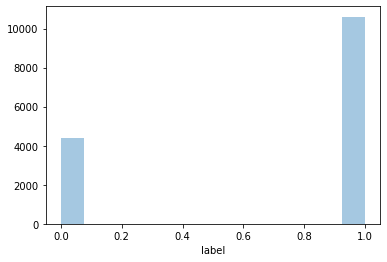

In [ ]:
sns.distplot(train['label'], kde=False)

# Directory settings

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './output'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = os.path.join(INPUT, MAIN_INPUT_NAME, "vinbigdata","train")
TEST_PATH = os.path.join(INPUT, MAIN_INPUT_NAME, "vinbigdata","test")

# Library

In [ ]:
!pip install -U albumentations
!pip install timm

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [ ]:
# ====================================================
# Library
# ====================================================

import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG["apex"]:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler, shutdown
    logger = getLogger(__name__)
    for h in logger.handlers:
        logger.removeHandler(h)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    '''handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler2)'''
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG["seed"])

# CV split

In [ ]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG["n_fold"], shuffle=True, random_state=CFG["seed"])
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG["target_col"]])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG["target_col"]]).size())

fold  label
0     0         878
      1        2122
1     0         879
      1        2121
2     0         879
      1        2121
3     0         879
      1        2121
4     0         879
      1        2121
dtype: int64


# Dataset

In [ ]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values + ".png"
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        #iimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image'].float()
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values + ".png"
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image'].float()
        return image

<class 'numpy.ndarray'>


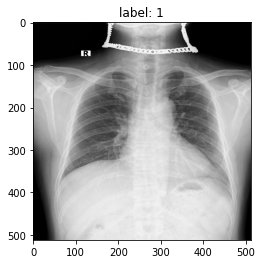

In [ ]:
# test
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    print(type(image))
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

# Transforms

In [ ]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG["size"], CFG["size"]),
            #RandomResizedCrop(CFG["size"], CFG["size"]),
            #Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(scale_limit=0.05, rotate_limit=5, p=0.5),
            Cutout(p=0.5),
            #VerticalFlip(p=0.5),
            #ShiftScaleRotate(p=0.5),
            #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],),
            ToTensorV2(p=1.0),
        ], p=1.)

    elif data == 'valid':
        return Compose([
            Resize(CFG["size"], CFG["size"]),
            #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],  ),
            ToTensorV2(p=1.0),
        ], p=1.)

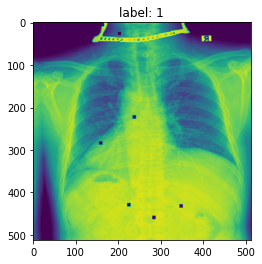

In [ ]:
# test
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

# MODEL

In [ ]:
# ====================================================
# MODEL
# ====================================================
class XrayImgClassifierEfficientnet(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG["target_size"])
    def forward(self, x):
        x = self.model(x)
        return x
class XrayImgClassifierVit(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224',  pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG["target_size"])
    def forward(self, x):
        x = self.model(x)
        return x
class XrayImgClassifierResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG["target_size"])

    def forward(self, x):
        x = self.model(x)
        return x

def get_model(pretrained=False):
    if CFG["architecture"] == "efficientnet":
      model = XrayImgClassifierEfficientnet(model_name=CFG["model_name"], pretrained=pretrained)
    elif CFG["architecture"] == "vit":
      model = XrayImgClassifierVit(model_name=CFG["model_name"], pretrained=pretrained)
    elif CFG["architecture"] == "resnet":
      model = XrayImgClassifierResNext(model_name=CFG["model_name"], pretrained=pretrained)
    return model

In [ ]:
# test
model = get_model()

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    print(image.shape)
    output = model(image)
    print(output)
    break

torch.Size([4, 3, 512, 512])
tensor([[-0.2353,  0.0033],
        [-0.2929, -0.1411],
        [-0.2696, -0.1506],
        [-0.2288,  0.0462]], grad_fn=<AddmmBackward>)


# Helper functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG["gradient_accumulation_steps"] > 1:
            loss = loss / CFG["gradient_accumulation_steps"]
        if CFG["apex"]:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["max_grad_norm"])
        if (step + 1) % CFG["gradient_accumulation_steps"] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG["print_freq"] == 0 or step == (len(train_loader)-1):
            LOGGER.info('Epoch(train): [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG["gradient_accumulation_steps"] > 1:
            loss = loss / CFG["gradient_accumulation_steps"]
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG["print_freq"] == 0 or step == (len(valid_loader)-1):
            LOGGER.info('EVAL(valid): [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: now{loss.val:.4f}(avg{loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG["batch_size"], 
                              shuffle=True, 
                              num_workers=CFG["num_workers"], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG["batch_size"], 
                              shuffle=False, 
                              num_workers=CFG["num_workers"], pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG["scheduler"]=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG["factor"], patience=CFG["patience"], verbose=True, eps=CFG["eps"])
        elif CFG["scheduler"]=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
        elif CFG["scheduler"]=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG["T_0"], T_mult=1, eta_min=CFG["min_lr"], last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = get_model(pretrained=True)
    
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG["apex"]:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG["epochs"]):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG["target_col"]].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))
        roc_auc = roc_auc_score(valid_labels, preds.argmax(1))
        f1 =  f1_score(valid_labels, preds.argmax(1))
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}　  Roc_auc:{roc_auc}  F1:{f1}')
        if fold==0:
            wandb.log({"avg_train_loss": avg_loss, "avg_val_loss":avg_val_loss, "val_accuracy":score, "val_roc_auc":roc_auc, "val_f1":f1})

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        os.path.join(OUTPUT_DIR,f'{CFG["model_name"]}_fold{fold}_best.pth'))
            wandb.save(os.path.join(OUTPUT_DIR,f'{CFG["model_name"]}_fold{fold}_best.pth'))
    
    check_point = torch.load( os.path.join(OUTPUT_DIR,f'{CFG["model_name"]}_fold{fold}_best.pth'))
    valid_folds[[str(c) for c in range(CFG["target_size"])]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG["target_col"]].values
        score = get_score(labels, preds)
        roc_auc = roc_auc_score(labels, preds)
        f1 =  f1_score(labels, preds)
        LOGGER.info(f'Accuracy: {score:<.5f}　  Roc_auc:{roc_auc:<.5f}  F1:{f1:<.5f}')

    if CFG["train"]:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG["n_fold"]):
            if fold in CFG["trn_fold"]:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG["inference"]:
        # inference
        model = get_model(pretrained=True)
        states = [torch.load(OUTPUT_DIR+f'{CFG["model_name"]}_fold{fold}_best.pth') for fold in CFG["trn_fold"]]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG["batch_size"], shuffle=False, 
                                 num_workers=CFG["num_workers"], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

# Train

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
Epoch(train): [1][0/1500] Data 0.496 (0.496) Elapsed 0m 1s (remain 29m 1s) Loss: 0.9266(0.9266) Grad: 15.4666  
Epoch(train): [1][100/1500] Data 0.000 (0.005) Elapsed 1m 4s (remain 14m 57s) Loss: 0.5568(0.4535) Grad: 10.0539  
Epoch(train): [1][200/1500] Data 0.000 (0.003) Elapsed 2m 8s (remain 13m 49s) Loss: 0.1622(0.4175) Grad: 2.4758  
Epoch(train): [1][300/1500] Data 0.000 (0.002) Elapsed 3m 11s (remain 12m 43s) Loss: 0.0578(0.3846) Grad: 0.7873  
Epoch(train): [1][400/1500] Data 0.000 (0.001) Elapsed 4m 15s (remain 11m 39s) Loss: 0.5104(0.3664) Grad: 5.9148  
Epoch(train): [1][500/1500] Data 0.000 (0.001) Elapsed 5m 18s (remain 10m 35s) Loss: 0.1996(0.3533) Grad: 3.4644  
Epoch(train): [1][600/1500] Data 0.000 (0.001) Elapsed 6m 22s (remain 9m 32s) Loss: 0.8131(0.3458) Grad: 7.2410  
Epoch(train)

In [ ]:
wandb.finish()